<a href="https://colab.research.google.com/github/Ananthrkulks/Ananthrkulks/blob/main/Malaria_Detection_by_Neuralearn_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
# Instead of importing np_utils, use tensorflow.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical
#Import BatchNormalization directly from tensorflow.keras.layers
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Activation,Dropout, BatchNormalization,InputLayer # Fixed import
from tensorflow.python.keras import Sequential,backend,optimizers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])




In [3]:
dataset



[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
dataset_info


tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

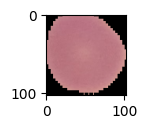

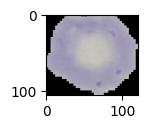

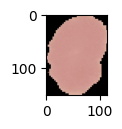

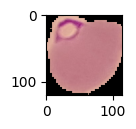

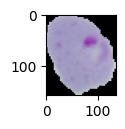

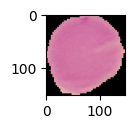

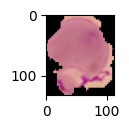

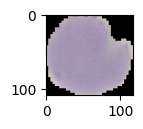

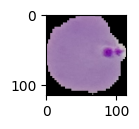

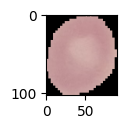

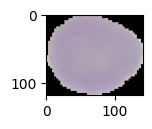

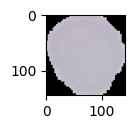

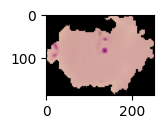

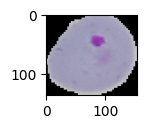

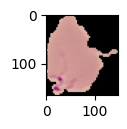

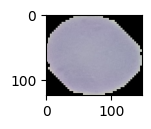

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the Malaria dataset
# The split argument was changed to 'train' to load only the training data
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split='train')

# Define ratios for splitting the dataset
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# Get the total number of examples in the dataset
# dataset is a tf.data.Dataset object, so we can use its methods
DATASET_SIZE = len(list(dataset))

# Split the dataset into train, validation, and test sets
train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

# Now you can iterate over the train_dataset to display images
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    # plt.title(dataset_info.features[]) # Uncomment and adjust this line to display labels if needed
    plt.show() # Display each image immediately



In [6]:
dataset_info.features['label'].int2str(0)

'parasitized'

**DATA PROCESSING**

In [7]:
IM_SIZE = 224
def resizing(image, label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0 , label

In [8]:
train_dataset = train_dataset.map(resizing)
val_dataset = val_dataset.map(resizing)
test_dataset = test_dataset.map(resizing)

train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [11]:
BATCH_SIZE = 32
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [12]:
BATCH_SIZE = 32
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [13]:
model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
                             tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, strides = 1, padding='valid',activation='sigmoid') # Corrected the typo here
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 6)         │             456 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 456 (1.78 KB)

 Trainable params: 456 (1.78 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#import tensorflow as tf

#IM_SIZE = 224

# ... (your other code)

model = tf.keras.Sequential([
                             tf.keras.layers.InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)), # Use tf.keras.layers.InputLayer
                             tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, strides = 1, padding='valid', activation='sigmoid') # Corrected kernel_size
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 456 (1.78 KB)

 Trainable params: 456 (1.78 KB)

 Non-trainable params: 0 (0.00 B)

**MODEL CREATION AND TRAINING**

In [15]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),  # Use tf.keras.layers.InputLayer
    tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),

])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

solve this tomorrow

**Hypothesis**--

The error arises because the BinaryCrossentropy loss function expects the inputs (y_true and y_pred) to be NumPy arrays or TensorFlow tensors, which have a shape attribute. However, you are providing Python lists, which do not have this attribute.

The traceback shows that the error originates within the squeeze_or_expand_to_same_rank function, which is called by the BinaryCrossentropy loss function. This function tries to access the shape of the inputs using x1.shape, leading to the AttributeError: 'list' object has no attribute 'shape'.

In [16]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]

# Convert the lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0863576>

In [24]:
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = ['accuracy'])
#metrics = RootMeanSquaredError()


In [26]:
histroy = model.fit(train_dataset,validation_data = val_dataset, epochs = 20, verbose = 1)

Epoch 1/100
  7/517 ━━━━━━━━━━━━━━━━━━━━ 19:35 2s/step - accuracy: 0.9201 - loss: 0.2097

KeyboardInterrupt: 

In [18]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>